# CS 7324-400B: Lab Seven - RNNs

#### Fall 2023
#### Author: Davis Vercher (49377022)

References & Citations
- **Download Link:**
  - https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews
- **Source:**
  - https://www.researchgate.net/publication/323545316_Statistical_Analysis_on_E-Commerce_Reviews_with_Sentiment_Classification_using_Bidirectional_Recurrent_Neural_Network

In [122]:
import pandas as pd
import numpy as np
import missingno as mn
import matplotlib.pyplot as plt
import string
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Bidirectional, Dropout, Embedding, SimpleRNN, Dense, LSTM
from keras.initializers import Constant
from keras.models import load_model
from sklearn.metrics import accuracy_score

## 0. Background and use case

### 0a. Business use case

**Task:** create a binary classification model that takes e-commerce review text and determines if the sentiment of the customer's review is positive or negative

**Business purpose/use case:** This model theoretically will allow the company to listen to the voice of their customers (specifically their sentiments towards specific products) and help them to uncover insights about their products via these customer reviews automatically. This would be especially useful if a company had a product with many thousands of reviews, meaning it would take a marketing team many man-hours to manually sift through reviews to understand general trends in sentiment.

### 0b. Additional Context

I chose this use case because it is an exact use case that my company implements today. We use a third-party text analytics software to automatically apply a sentiment analysis score to online ecommerce reviews. Since it is a proprietary software, I do not know how it actually works. I am excited to dive in and learn a bit about how RNNs make that software work.

## 1. Preparation

### 1a. Define and prepare dataset

#### 1a1. Dataset overview

The dataset chosen is a customer review dataset containing ~23,000 individual customer reviews on an assortment of different women's clothing items. Each review contains the age of the reviewer, an open text title, open text review, a rating of the product from 1 to 5 (5 being the highest), whether the customer does or does not recommend the product (0 for not recommended, 1 for recommended), and the class name of the item being reviewed (e.g., dresses, blouses, outerwear, etc.).

For performance reasons (I do not have easy GPU access), I will reduce the dataset down to around 5,000 rows from the original 23,000. This will make lemmatization during preprocessing and the model training less time intensive.

Every review has an age input. A very small portion of reviews do not have any input for the 'review' column, but a larger minority do not include any input for the 'title' column (while still having an associated input for the 'review'). All reviews have a 1 to 5 start rating and a 0 or 1 for whether the product in question is or is not recommended by the customer.

#### 1a2. Loading the dataset and initial visualization/cleaning

In [2]:
full_df = pd.read_csv('ecommerce_reviews.csv')

In [3]:
full_df.head()

,Age,Title,Review_Text,Rating,Recommended,Class_Name
0,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,Intimates
1,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,Dresses
2,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,Dresses
3,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,Pants
4,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,Blouses


In [4]:
print(len(full_df))

23472


In [5]:
print(full_df.duplicated(['Review_Text']).sum())

850


In [6]:
full_df = full_df.drop_duplicates(subset=['Review_Text'])

In [7]:
print(full_df.duplicated(['Review_Text']).sum())

0


In [8]:
print(len(full_df))

22622


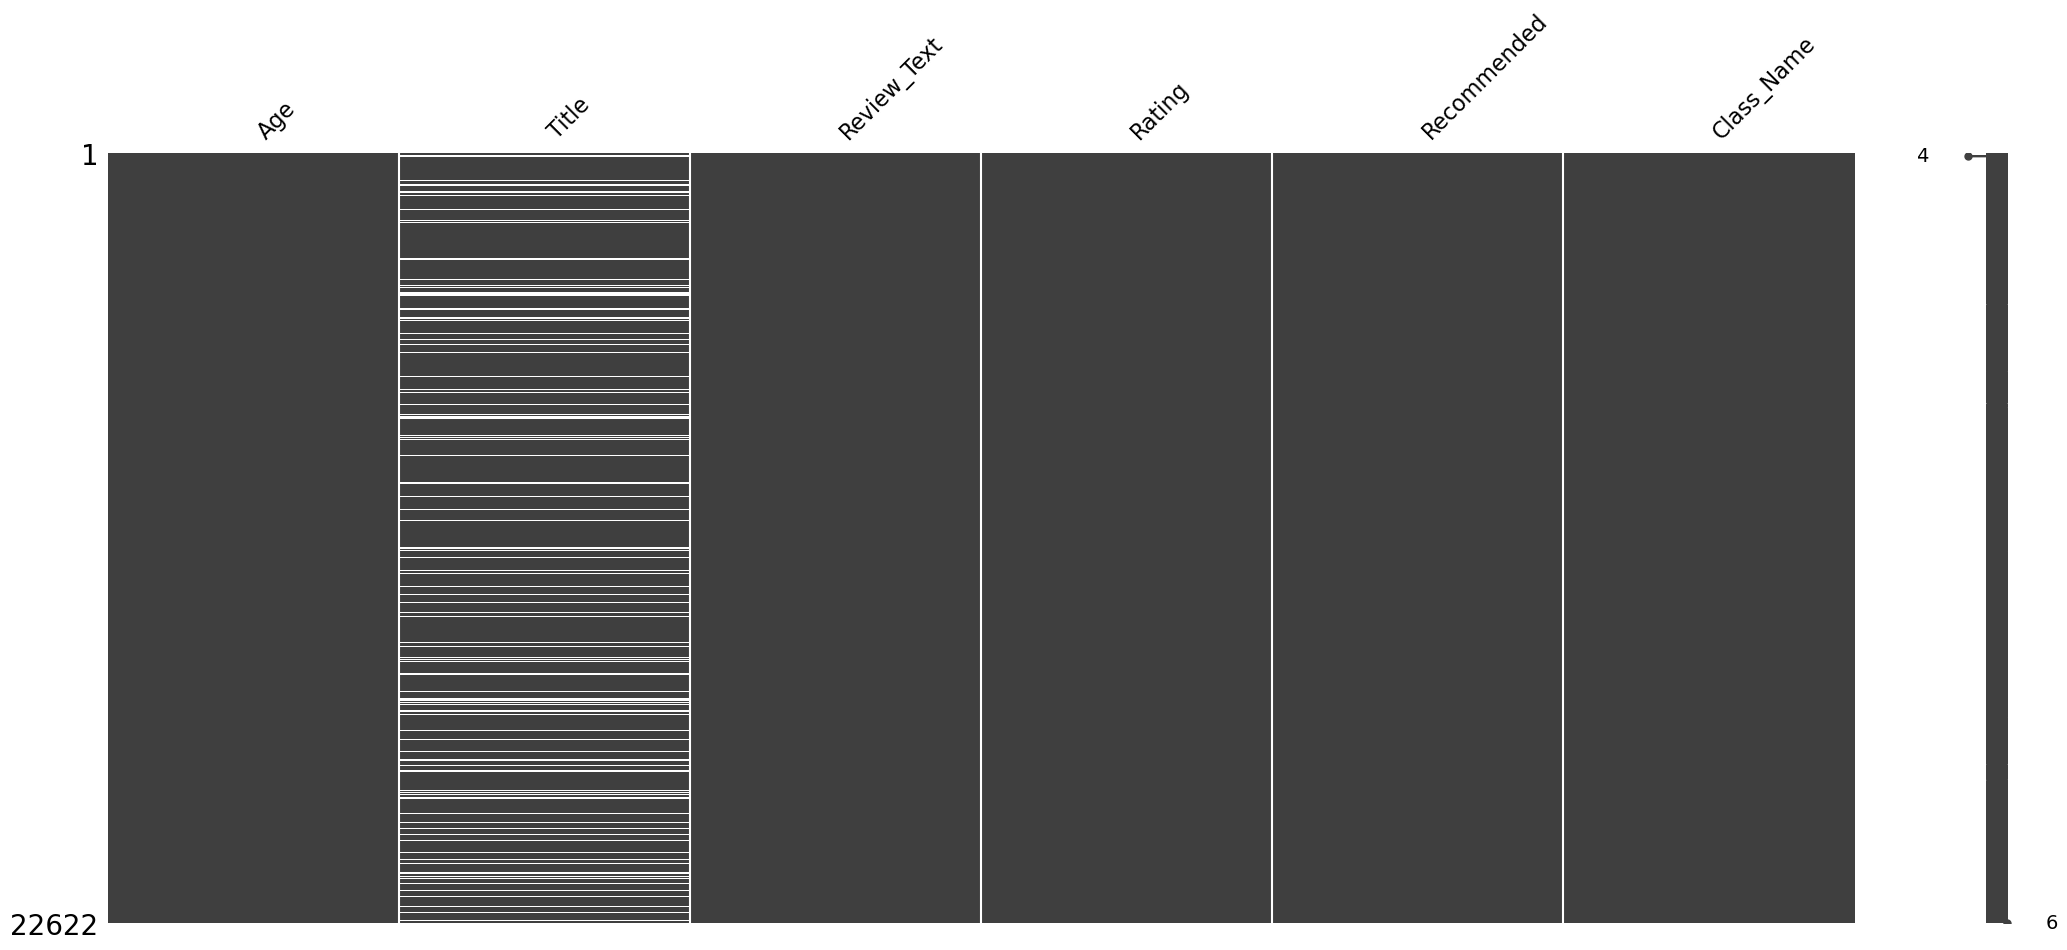

In [9]:
mn.matrix(full_df)
plt.show()

In [10]:
print(full_df.isna().sum())

Age               0
Title          2966
Review_Text       1
Rating            0
Recommended       0
Class_Name        0
dtype: int64


In [11]:
full_df.dropna(subset=['Review_Text'], inplace=True)

In [12]:
print(full_df.isna().sum())

Age               0
Title          2965
Review_Text       0
Rating            0
Recommended       0
Class_Name        0
dtype: int64


Now that I've reduced the null values I don't want, I need to reduce the dataset down to 5,000 entries (as discussed above). I will do this by randomly sampling 2,500 entries from 'Recommended' = 0 (i.e., negative review) and 2,500 entries from 'Recommended' = 1 (i.e., positive review). This will even out my target variable and balance the used dataset.

In [13]:
full_df.head()

,Age,Title,Review_Text,Rating,Recommended,Class_Name
0,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,Intimates
1,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,Dresses
2,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,Dresses
3,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,Pants
4,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,Blouses


In [14]:
full_df['Recommended'] = full_df['Recommended'].astype(int)

In [15]:
full_df.head()

,Age,Title,Review_Text,Rating,Recommended,Class_Name
0,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,Intimates
1,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,Dresses
2,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,Dresses
3,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,Pants
4,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,Blouses


In [16]:
df_0 = full_df[full_df['Recommended'] == 0]
df_1 = full_df[full_df['Recommended'] == 1]

In [17]:
sampled_0 = df_0.sample(n=2500, random_state=17)
sampled_1 = df_1.sample(n=2500, random_state=17)

df = pd.concat([sampled_0, sampled_1]).reset_index(drop=True)

In [18]:
df = df.sample(frac=1).reset_index(drop=True)

In [19]:
df.head()

,Age,Title,Review_Text,Rating,Recommended,Class_Name
0,35,Unflattering fit,This dress runs a bit small. the large arm hol...,3,0,Dresses
1,39,Velvet crush,This dress is so soft and cozy and pretty. lo...,5,1,Dresses
2,29,"Must have, elegant, chic",This top! i was hesitant to try this on becaus...,5,1,Blouses
3,32,Love these!,These pants are so comfy i'm getting a second ...,5,1,Pants
4,26,NaN,"So, this is just the most lovely romper. beaut...",3,1,Dresses


I now have only null values in the "Title" column. I am leaving in these title-less entries since there are quite a few and the presence of a title is not critical to our evaluation of the "Review_Text" column for sentiment analysis.

This data is now ready for tokenization.

#### 1a3. Tokenization

I have never done any NLP work before, and need some help understanding the fundamentals of tokenization. For that I turned to ChatGPT-4.

Conversation Link: https://chat.openai.com/share/232ddde5-3c9b-4621-b2bf-787393de32af

Since this is my first time doing a recurrent network, I want to experience a more basic implemenation of tokenization to begin (word-level tokenization). If I feel comfortable experimenting with this more basic tokenization, I plan to move onto a more appropriate tokenization for this use case, such as subword byte pair encoding (BPE). This approach is more appropriate theoritically for this dataset and use case because it splits words into smaller more frequent subwords/subunits and can lead to a better handling by the model of words not encountered in training (such as we expect from the varied and complicated inputs of open-text customer reviews).

Before I can tokenize the entries of the 'Review_Text' column, I need to do some preprocessing (i.e., removing punctuation or making all letter lowercase) and reduce the vocabulary (i.e., removing 'stopwords' like 'is' or 'the' that don't contribute to the meaning). This will help reduce the complexity of the full token vocabulary.

In [20]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dvercher\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dvercher\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

In [22]:
def process_text(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [word for word in tokens if word not in stop_words and word not in punctuation]
    return ' '.join(filtered_tokens)

I also want to apply lemmatization my tokens so that words like 'running', 'runs', and 'run' all tokenize to just 'run'. This reduces the vocabulary size as well.

In [24]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dvercher\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\dvercher\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [25]:
lemmatizer = WordNetLemmatizer()

In [26]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_sentence(sentence):
    tokens = word_tokenize(sentence)
    lemmatized_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]
    return ' '.join(lemmatized_tokens)

In [27]:
# Example of how this works from ChatGPT-4... very interesting!
sentence = "The cats are chasing the mice."
lemmatized_sentence = lemmatize_sentence(sentence)
print(lemmatized_sentence)

The cat be chase the mouse .


In [28]:
def process(text, index, total):
    if index % 500 == 0:
        print(f"Processing {index} of {total}")
    return process_text(lemmatize_sentence(text))

In [29]:
total = len(df)
df['Reviews_Processed'] = [process(text, i, total) for i, text in enumerate(df['Review_Text'])]

Processing 0 of 5000
Processing 500 of 5000
Processing 1000 of 5000
Processing 1500 of 5000
Processing 2000 of 5000
Processing 2500 of 5000
Processing 3000 of 5000
Processing 3500 of 5000
Processing 4000 of 5000
Processing 4500 of 5000


In [30]:
df.head()

,Age,Title,Review_Text,Rating,Recommended,Class_Name,Reviews_Processed
0,35,Unflattering fit,This dress runs a bit small. the large arm hol...,3,0,Dresses,dress run bit small large arm hole unflatterin...
1,39,Velvet crush,This dress is so soft and cozy and pretty. lo...,5,1,Dresses,dress soft cozy pretty love shine interest she...
2,29,"Must have, elegant, chic",This top! i was hesitant to try this on becaus...,5,1,Blouses,top hesitant try felt busy however must 's rig...
3,32,Love these!,These pants are so comfy i'm getting a second ...,5,1,Pants,pant comfy 'm get second pair order olive colo...
4,26,NaN,"So, this is just the most lovely romper. beaut...",3,1,Dresses,lovely romper beautifully make flowey comforta...


In [31]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000)

In [32]:
tokenizer.fit_on_texts(df['Reviews_Processed'])

In [33]:
sequences = tokenizer.texts_to_sequences(df['Reviews_Processed'])

In [34]:
max_length = 100
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

In [35]:
df['Tokenized_Reviews'] = list(padded_sequences)
df.head()

,Age,Title,Review_Text,Rating,Recommended,Class_Name,Reviews_Processed,Tokenized_Reviews
0,35,Unflattering fit,This dress runs a bit small. the large arm hol...,3,0,Dresses,dress run bit small large arm hole unflatterin...,"[1, 49, 50, 14, 29, 76, 204, 207, 14, 112, 33,..."
1,39,Velvet crush,This dress is so soft and cozy and pretty. lo...,5,1,Dresses,dress soft cozy pretty love shine interest she...,"[1, 48, 411, 59, 7, 2343, 431, 1287, 1595, 493..."
2,29,"Must have, elegant, chic",This top! i was hesitant to try this on becaus...,5,1,Blouses,top hesitant try felt busy however must 's rig...,"[6, 1085, 25, 135, 1876, 71, 349, 9, 81, 508, ..."
3,32,Love these!,These pants are so comfy i'm getting a second ...,5,1,Pants,pant comfy 'm get second pair order olive colo...,"[67, 203, 13, 22, 366, 122, 18, 1086, 11, 14, ..."
4,26,NaN,"So, this is just the most lovely romper. beaut...",3,1,Dresses,lovely romper beautifully make flowey comforta...,"[138, 580, 350, 19, 2756, 51, 121, 106, 859, 2..."


### 1b. Metrics

I will be using accuracy as my primary metric. This is because I have a balanced dataset (equal number of 'yes' recommended reviews to 'no' recommended). Since I am training a binary classification model with a balanced dataset, accuracy will be my starting point.

### 1c. Data splitting

I will be starting with a simple 80/20 split. Because my data is perfectly balanced between the two target classes, and because I have shuffled my data so that both classes are randomly dispersed throughout, I feel fine to begin with this simple split.

In [36]:
X = df['Tokenized_Reviews']
y = df['Recommended']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size=0.2)

In [38]:
X.head()

0    [1, 49, 50, 14, 29, 76, 204, 207, 14, 112, 33,...
1    [1, 48, 411, 59, 7, 2343, 431, 1287, 1595, 493...
2    [6, 1085, 25, 135, 1876, 71, 349, 9, 81, 508, ...
3    [67, 203, 13, 22, 366, 122, 18, 1086, 11, 14, ...
4    [138, 580, 350, 19, 2756, 51, 121, 106, 859, 2...
Name: Tokenized_Reviews, dtype: object

In [39]:
y.head()

0    0
1    1
2    1
3    1
4    1
Name: Recommended, dtype: int32

In [40]:
print(X_train)

3802    [209, 409, 1, 170, 101, 158, 1, 1204, 128, 158...
674     [1, 23, 37, 2, 196, 10, 116, 90, 3916, 502, 1,...
1765    [23, 172, 580, 239, 2, 8, 69, 285, 4480, 53, 2...
3473    [7, 66, 2, 77, 25, 94, 78, 10, 4, 90, 148, 4, ...
4500    [1776, 139, 27, 105, 88, 162, 61, 12, 10, 196,...
                              ...                        
4645    [151, 150, 47, 422, 129, 38, 150, 250, 82, 330...
2425    [466, 148, 437, 308, 129, 549, 62, 16, 75, 150...
4852    [187, 360, 7, 203, 67, 386, 209, 10, 116, 53, ...
4562    [7, 98, 1085, 25, 1, 5, 2, 17, 79, 744, 2, 17,...
1234    [50, 649, 11, 37, 94, 30, 56, 267, 531, 142, 1...
Name: Tokenized_Reviews, Length: 4000, dtype: object


In [41]:
X_train = np.array(X_train.tolist())
X_test = np.array(X_test.tolist())

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [42]:
print(X_train[0])

[2.090e+02 4.090e+02 1.000e+00 1.700e+02 1.010e+02 1.580e+02 1.000e+00
 1.204e+03 1.280e+02 1.580e+02 9.900e+01 3.700e+01 2.000e+03 1.300e+01
 6.480e+02 1.260e+02 7.800e+01 1.000e+01 4.000e+00 2.500e+01 2.280e+02
 4.000e+00 6.200e+01 6.380e+02 2.330e+02 1.500e+01 3.620e+02 5.000e+01
 1.420e+02 1.070e+02 7.100e+01 1.200e+01 3.400e+01 2.090e+02 9.200e+01
 4.000e+00 5.580e+02 5.340e+02 4.520e+02 5.000e+01 3.000e+00 1.500e+01
 3.700e+01 3.120e+02 4.000e+01 1.030e+02 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000

In [43]:
print(y_train[0])

0.0


## 2. Modeling

### 2a. RNN Architecture One: Simple RNN

#### 2a1. Variant 1

In [44]:
max_length = 100
vocab_size = 10000
embedding_dim = 50

In [45]:
model_1a = Sequential()
model_1a.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model_1a.add(SimpleRNN(64))
model_1a.add(Dense(1, activation='sigmoid'))

model_1a.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_1a.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           500000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                7360      
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 507,425
Trainable params: 507,425
Non-trainable params: 0
_________________________________________________________________


In [46]:
save_name = 'model_1a.h5'
checkpoint = ModelCheckpoint(save_name, save_best_only=True)

In [47]:
history = model_1a.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/20
125/125 [==============================] - 3s 13ms/step - loss: 0.6955 - accuracy: 0.5135 - val_loss: 0.6935 - val_accuracy: 0.4880
Epoch 2/20
125/125 [==============================] - 1s 11ms/step - loss: 0.6956 - accuracy: 0.5107 - val_loss: 0.6931 - val_accuracy: 0.5140
Epoch 3/20
125/125 [==============================] - 1s 11ms/step - loss: 0.6996 - accuracy: 0.5157 - val_loss: 0.6930 - val_accuracy: 0.5030
Epoch 4/20
125/125 [==============================] - 1s 11ms/step - loss: 0.6959 - accuracy: 0.5210 - val_loss: 0.6894 - val_accuracy: 0.5510
Epoch 5/20
125/125 [==============================] - 2s 13ms/step - loss: 0.6939 - accuracy: 0.5265 - val_loss: 0.6860 - val_accuracy: 0.5510
Epoch 6/20
125/125 [==============================] - 1s 11ms/step - loss: 0.6906 - accuracy: 0.5497 - val_loss: 0.7011 - val_accuracy: 0.5120
Epoch 7/20
125/125 [==============================] - 2s 12ms/step - loss: 0.6786 - accuracy: 0.5905 - val_loss: 0.6751 - val_accuracy: 0.5750

I am skeptical that this model got to an accuracy in the low 60% range. Let's see how a more complicated version of this model performs.

#### 2a2. Variant 2

In [48]:
max_length = 100
vocab_size = 10000
embedding_dim = 30

In [60]:
model_1b = Sequential()
model_1b.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model_1b.add(SimpleRNN(128, return_sequences=True))
model_1b.add(SimpleRNN(256, return_sequences=True))
model_1b.add(Dropout(0.3))
model_1b.add(Dense(1, activation='sigmoid'))

model_1b.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_1b.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 30)           300000    
                                                                 
 simple_rnn_12 (SimpleRNN)   (None, 100, 128)          20352     
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, 100, 256)          98560     
                                                                 
 dropout_7 (Dropout)         (None, 100, 256)          0         
                                                                 
 dense_5 (Dense)             (None, 100, 1)            257       
                                                                 
Total params: 419,169
Trainable params: 419,169
Non-trainable params: 0
_________________________________________________________________


In [57]:
save_name = 'model_1b.h5'
checkpoint = ModelCheckpoint(save_name, save_best_only=True)

In [58]:
history = model_1b.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/20
125/125 [==============================] - 9s 58ms/step - loss: 0.7060 - accuracy: 0.5100 - val_loss: 0.6978 - val_accuracy: 0.5028
Epoch 2/20
125/125 [==============================] - 7s 56ms/step - loss: 0.7073 - accuracy: 0.5013 - val_loss: 0.6925 - val_accuracy: 0.5092
Epoch 3/20
125/125 [==============================] - 7s 54ms/step - loss: 0.6954 - accuracy: 0.5174 - val_loss: 0.8217 - val_accuracy: 0.5046
Epoch 4/20
125/125 [==============================] - 7s 55ms/step - loss: 0.6816 - accuracy: 0.5558 - val_loss: 0.5654 - val_accuracy: 0.7542
Epoch 5/20
125/125 [==============================] - 7s 54ms/step - loss: 0.6125 - accuracy: 0.6991 - val_loss: 0.6720 - val_accuracy: 0.6235
Epoch 6/20
125/125 [==============================] - 7s 53ms/step - loss: 0.6031 - accuracy: 0.7131 - val_loss: 0.6238 - val_accuracy: 0.6811
Epoch 7/20
125/125 [==============================] - 7s 54ms/step - loss: 0.5909 - accuracy: 0.7136 - val_loss: 0.6289 - val_accuracy: 0.7128

This variant of the model performed slightly better, with best accuracy in the high 70% range.

### 2b. RNN Architecture Two: Long Short-Term Memory

#### 2b1. Variant 1

In [62]:
max_length = 100
vocab_size = 10000
embedding_dim = 30

In [63]:
model_2a = Sequential()
model_2a.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model_2a.add(LSTM(128, return_sequences=True))
model_2a.add(LSTM(256, return_sequences=True))
model_2a.add(Dropout(0.3))
model_2a.add(Dense(1, activation='sigmoid'))

model_2a.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

model_2a.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 30)           300000    
                                                                 
 lstm (LSTM)                 (None, 100, 128)          81408     
                                                                 
 lstm_1 (LSTM)               (None, 100, 256)          394240    
                                                                 
 dropout_8 (Dropout)         (None, 100, 256)          0         
                                                                 
 dense_6 (Dense)             (None, 100, 1)            257       
                                                                 
Total params: 775,905
Trainable params: 775,905
Non-trainable params: 0
_________________________________________________________________


In [64]:
save_name = 'model_2a.h5'
checkpoint = ModelCheckpoint(save_name, save_best_only=True)

In [65]:
history = model_2a.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/20
125/125 [==============================] - 41s 310ms/step - loss: 0.6194 - accuracy: 0.6394 - val_loss: 0.5165 - val_accuracy: 0.7828
Epoch 2/20
125/125 [==============================] - 41s 329ms/step - loss: 0.4165 - accuracy: 0.8338 - val_loss: 0.4777 - val_accuracy: 0.7662
Epoch 3/20
125/125 [==============================] - 40s 316ms/step - loss: 0.3289 - accuracy: 0.8752 - val_loss: 0.3949 - val_accuracy: 0.8303
Epoch 4/20
125/125 [==============================] - 38s 306ms/step - loss: 0.2661 - accuracy: 0.9024 - val_loss: 0.4621 - val_accuracy: 0.8093
Epoch 5/20
125/125 [==============================] - 38s 305ms/step - loss: 0.2535 - accuracy: 0.9079 - val_loss: 0.4403 - val_accuracy: 0.8226
Epoch 6/20
125/125 [==============================] - 39s 316ms/step - loss: 0.2473 - accuracy: 0.9108 - val_loss: 0.4714 - val_accuracy: 0.8108
Epoch 7/20
125/125 [==============================] - 38s 302ms/step - loss: 0.2094 - accuracy: 0.9256 - val_loss: 0.5161 - val_ac

#### 2b2. Variant 2

In [68]:
max_length = 100
vocab_size = 10000
embedding_dim = 30

In [73]:
model_2b = Sequential()
model_2b.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model_2b.add(LSTM(128, return_sequences=True))
model_2b.add(LSTM(256, return_sequences=True))
model_2b.add(Dropout(0.3))
model_2b.add(Dense(64, activation='relu'))
model_2b.add(Dropout(0.3))
model_2b.add(Dense(1, activation='sigmoid'))

model_2b.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

model_2b.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 100, 30)           300000    
                                                                 
 lstm_5 (LSTM)               (None, 100, 128)          81408     
                                                                 
 lstm_6 (LSTM)               (None, 100, 256)          394240    
                                                                 
 dropout_11 (Dropout)        (None, 100, 256)          0         
                                                                 
 dense_9 (Dense)             (None, 100, 64)           16448     
                                                                 
 dropout_12 (Dropout)        (None, 100, 64)           0         
                                                                 
 dense_10 (Dense)            (None, 100, 1)           

In [74]:
save_name = 'model_2b.h5'
checkpoint = ModelCheckpoint(save_name, save_best_only=True)

In [75]:
history = model_2b.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/20
125/125 [==============================] - 46s 345ms/step - loss: 0.5673 - accuracy: 0.6900 - val_loss: 0.4110 - val_accuracy: 0.8255
Epoch 2/20
125/125 [==============================] - 39s 316ms/step - loss: 0.3707 - accuracy: 0.8476 - val_loss: 0.4116 - val_accuracy: 0.8209
Epoch 3/20
125/125 [==============================] - 39s 315ms/step - loss: 0.3254 - accuracy: 0.8770 - val_loss: 0.4057 - val_accuracy: 0.8226
Epoch 4/20
125/125 [==============================] - 40s 316ms/step - loss: 0.2770 - accuracy: 0.8981 - val_loss: 0.4599 - val_accuracy: 0.8260
Epoch 5/20
125/125 [==============================] - 39s 315ms/step - loss: 0.2424 - accuracy: 0.9110 - val_loss: 0.4672 - val_accuracy: 0.8161
Epoch 6/20
125/125 [==============================] - 39s 316ms/step - loss: 0.2517 - accuracy: 0.9114 - val_loss: 0.5986 - val_accuracy: 0.7605
Epoch 7/20
125/125 [==============================] - 39s 315ms/step - loss: 0.2242 - accuracy: 0.9198 - val_loss: 0.5259 - val_ac

Overall, the LSTM models performed on average better than the Simple RNN models. 

### 2c. GloVe & second chain applied to "best model"

In [85]:
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [88]:
embedding_dim = 100  # or the dimension you chose
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:  # Corrected line
            embedding_matrix[i] = embedding_vector

In [92]:
embedding_layer = Embedding(vocab_size,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

In [93]:
model_glove = Sequential()
model_glove.add(embedding_layer)
model_glove.add(LSTM(128, return_sequences=True))
model_glove.add(LSTM(256, return_sequences=True))
model_glove.add(Dropout(0.3))
model_glove.add(Dense(64, activation='relu'))
model_glove.add(Dropout(0.3))
model_glove.add(Dense(1, activation='sigmoid'))

model_glove.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

model_glove.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 100, 100)          1000000   
                                                                 
 lstm_14 (LSTM)              (None, 100, 128)          117248    
                                                                 
 lstm_15 (LSTM)              (None, 100, 256)          394240    
                                                                 
 dropout_18 (Dropout)        (None, 100, 256)          0         
                                                                 
 dense_16 (Dense)            (None, 100, 64)           16448     
                                                                 
 dropout_19 (Dropout)        (None, 100, 64)           0         
                                                                 
 dense_17 (Dense)            (None, 100, 1)          

In [94]:
save_name = 'model_glove.h5'
checkpoint = ModelCheckpoint(save_name, save_best_only=True)

In [95]:
history = model_glove.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/20
125/125 [==============================] - 48s 361ms/step - loss: 0.6675 - accuracy: 0.5921 - val_loss: 0.5870 - val_accuracy: 0.7047
Epoch 2/20
125/125 [==============================] - 40s 321ms/step - loss: 0.5704 - accuracy: 0.7196 - val_loss: 0.5640 - val_accuracy: 0.7381
Epoch 3/20
125/125 [==============================] - 42s 339ms/step - loss: 0.5331 - accuracy: 0.7437 - val_loss: 0.5130 - val_accuracy: 0.7585
Epoch 4/20
125/125 [==============================] - 39s 312ms/step - loss: 0.4937 - accuracy: 0.7629 - val_loss: 0.4777 - val_accuracy: 0.7760
Epoch 5/20
125/125 [==============================] - 40s 323ms/step - loss: 0.4742 - accuracy: 0.7856 - val_loss: 0.4742 - val_accuracy: 0.7925
Epoch 6/20
125/125 [==============================] - 39s 316ms/step - loss: 0.4422 - accuracy: 0.7998 - val_loss: 0.4429 - val_accuracy: 0.8008
Epoch 7/20
125/125 [==============================] - 40s 319ms/step - loss: 0.4212 - accuracy: 0.8083 - val_loss: 0.4493 - val_ac

Overall this model did not perform much better than the non-GloVe version.

### 2d. Visualize results of all RNNs

#### 2d1. Creating a new training set to test all trained models

I will now create a non-overlapping smaller sample from the original 23,000 entry dataset. This will be a final test set I will test the accuracy of each trained RNN model against. Then I will visualize.

In [97]:
original_sampled_0 = df_0.sample(n=2500, random_state=17)
original_sampled_1 = df_1.sample(n=2500, random_state=17)

remaining_0 = df_0.drop(original_sampled_0.index)
remaining_1 = df_1.drop(original_sampled_1.index)

new_sampled_0 = remaining_0.sample(n=250, random_state=21)
new_sampled_1 = remaining_1.sample(n=250, random_state=21)

test_df = pd.concat([new_sampled_0, new_sampled_1]).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

In [104]:
print(len(test_df[test_df['Recommended'] == 0]))
print(len(test_df[test_df['Recommended'] == 1]))
print(len(test_df))

250
250
500


In [108]:
total = len(test_df)
test_df['Reviews_Processed'] = [process(text, i, total) for i, text in enumerate(test_df['Review_Text'])]

Processing 0 of 500


In [109]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000)

In [110]:
tokenizer.fit_on_texts(test_df['Reviews_Processed'])

In [111]:
sequences = tokenizer.texts_to_sequences(test_df['Reviews_Processed'])

In [112]:
max_length = 100
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

In [114]:
test_df['Tokenized_Reviews'] = list(padded_sequences)
df.head()

,Age,Title,Review_Text,Rating,Recommended,Class_Name,Reviews_Processed,Tokenized_Reviews
0,35,Unflattering fit,This dress runs a bit small. the large arm hol...,3,0,Dresses,dress run bit small large arm hole unflatterin...,"[1, 49, 50, 14, 29, 76, 204, 207, 14, 112, 33,..."
1,39,Velvet crush,This dress is so soft and cozy and pretty. lo...,5,1,Dresses,dress soft cozy pretty love shine interest she...,"[1, 48, 411, 59, 7, 2343, 431, 1287, 1595, 493..."
2,29,"Must have, elegant, chic",This top! i was hesitant to try this on becaus...,5,1,Blouses,top hesitant try felt busy however must 's rig...,"[6, 1085, 25, 135, 1876, 71, 349, 9, 81, 508, ..."
3,32,Love these!,These pants are so comfy i'm getting a second ...,5,1,Pants,pant comfy 'm get second pair order olive colo...,"[67, 203, 13, 22, 366, 122, 18, 1086, 11, 14, ..."
4,26,NaN,"So, this is just the most lovely romper. beaut...",3,1,Dresses,lovely romper beautifully make flowey comforta...,"[138, 580, 350, 19, 2756, 51, 121, 106, 859, 2..."


In [115]:
X = test_df['Tokenized_Reviews']
y = test_df['Recommended']

In [117]:
X = np.array(X.tolist())
X = X.astype('float32')

y = y.astype('float32')

#### 2d2. Visualizing

In [123]:
models = ['model_1a.h5', 'model_1b.h5', 'model_2a.h5', 'model_2b.h5', 'model_glove.h5']
predictions = {}
accuracies = {}

for h5 in models:
    model = load_model(h5)
    prediction = model.predict(X)
    predicted_classes = np.argmax(prediction, axis=1)
    predictions[h5] = predicted_classes
    
    accuracy = accuracy_score(y, predicted_classes)
    accuracies[h5] = (accuracy * 100).astype(int)
    print(f"Accuracy for {h5}: {accuracy * 100:.1f}%")

16/16 [==============================] - 0s 3ms/step
Accuracy for model_1a.h5: 50.0%
16/16 [==============================] - 1s 18ms/step
Accuracy for model_1b.h5: 19.6%
16/16 [==============================] - 2s 67ms/step
Accuracy for model_2a.h5: 12.0%
16/16 [==============================] - 2s 61ms/step
Accuracy for model_2b.h5: 12.6%
16/16 [==============================] - 2s 64ms/step
Accuracy for model_glove.h5: 7.8%


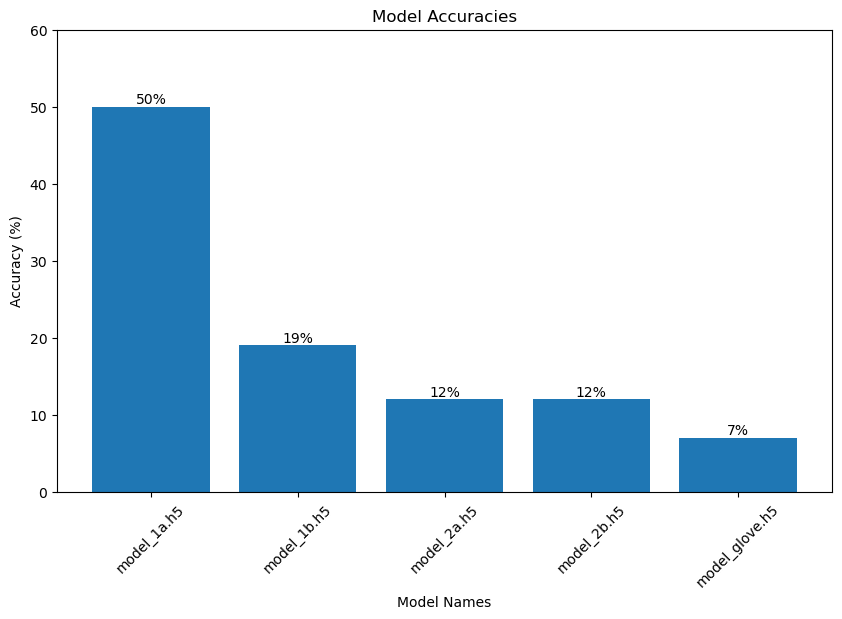

In [124]:
model_names = list(accuracies.keys())
accuracy_numbers = list(accuracies.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracy_numbers)

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{round(bar.get_height())}%", va='bottom', ha='center')

plt.xlabel('Model Names')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracies')
plt.ylim(0, 60)
plt.xticks(rotation=45)
plt.show()

In the end, I can see that none of my models actually performed well on novel data not seen in the original training/testing. 

The "best" performing model only had an accuracy as good as random choice (for a binary classification problem). The other models all performed far worse than random choice.

I think two things contribute to this:
- 1: My models likely massively overfit to the original training/testing data
- 2: The measuring stick I was using for this supervised training was the "Recommended" column (0 or 1 for if the reviewer would recommend the product. Though this is a fair heuristic for a person's sentiment about the product, not every open text review would necessarily have sentiment identifying words that match exactly to whether or not they would actually recommend the product. For example, someone may have a positive view of the company and express that in their review, but ultimately be a 0 in the recommendation column (if they don't specifically like the actual product).

Overall it is frustrating to me to not have well performing models on novel data (for this lab and for the previous lab -- CNNs).

I have learned a great deal during this course but ultimately have failed to progress completely to the stage of mastery of machine learning that would enable me to make actually useful neural networks.

Thank you for everything you have done for me during this course!... my machine learning journey continues!